In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import numpy as np
from copy import deepcopy # 모델 파라미터값 깊은 복사 (베스트 모델 저장을 위함)
from torch.utils.data import TensorDataset

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train= pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test=pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [5]:
display(train)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train.shape

(42000, 785)

In [7]:
X_train= train.drop(['label'],axis= 1).values
y_train=train['label'].values
X_test=test

In [8]:
print(X_train.shape, y_train.shape)
#x_train은 2차원 텐서 , y_train은 벡터

(42000, 784) (42000,)


In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [10]:
#픽셀 28*28 
X_train=X_train.reshape(-1,1,28,28)
X_train.shape

(42000, 1, 28, 28)

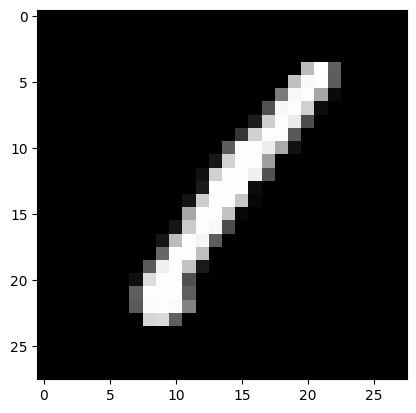

In [11]:
import matplotlib.pyplot as plt

# 예시로 첫 번째 이미지를 출력해봅시다.
image_index = 0
image = X_train[image_index, 0]  # 42000개 중 첫 번째 이미지 선택, 채널 차원 제거
plt.imshow(image, cmap='gray')  # 흑백 이미지로 표시
plt.show()


In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, shuffle=True)

In [13]:
X_train.shape

(33600, 1, 28, 28)

In [14]:
X_train = torch.tensor(X_train, dtype=torch.float32)  
y_train = torch.tensor(y_train, dtype=torch.long)     
X_val = torch.tensor(X_val, dtype=torch.float32)     
y_val = torch.tensor(y_val, dtype=torch.long)         


In [15]:
train_dataset=TensorDataset(X_train, y_train)
train_batches=DataLoader(train_dataset,batch_size=128,shuffle=True)

val_dataset=TensorDataset(X_val, y_val)
val_batches=DataLoader(val_dataset,batch_size=128, shuffle=True)

In [16]:
X_train.shape

torch.Size([33600, 1, 28, 28])

In [17]:
m=nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1,bias=False)
print(m(X_train).shape)


torch.Size([33600, 32, 28, 28])


In [18]:
class CNNModel(nn.Module):
        
    def __init__(self):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),            
            nn.AvgPool2d(2),
                
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),            
            nn.AvgPool2d(2),
               
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),            
            nn.AvgPool2d(2)
        )
            
        self.linear_layers = nn.Sequential(
            nn.Linear(128*3*3, 64),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64),
                
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(32),
                
            nn.Linear(32, 10), 
            nn.LeakyReLU(0.1),
            nn.Softmax(dim=1)  
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  
        x = self.linear_layers(x)
        return x


In [19]:
model=CNNModel().to(device)
minibatch_size=128
optimizer= torch.optim.Adam(model.parameters())
loss_func=nn.CrossEntropyLoss()

nb_epochs=50
early_stop=10
progress_interval=5

In [20]:
def train_model(model, early_stop, n_epochs, progress_interval):
    
    train_losses, valid_losses, lowest_loss = list(), list(), np.inf

   
    for epoch in range(n_epochs):
        
        train_loss, valid_loss = 0, 0
        
        model.train()
        
        for x_minibatch, y_minibatch in train_batches:
            x_minibatch = x_minibatch.to(device)
            y_minibatch = y_minibatch.to(device)
            y_minibatch_pred = model(x_minibatch)
            loss = loss_func(y_minibatch_pred, y_minibatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss = train_loss / len(train_batches)
        train_losses.append(train_loss)      
        
    
        model.eval()
        with torch.no_grad():
            for x_minibatch, y_minibatch in val_batches:
                x_minibatch = x_minibatch.to(device)
                y_minibatch = y_minibatch.to(device)
                y_minibatch_pred = model(x_minibatch)
                loss = loss_func(y_minibatch_pred, y_minibatch)
                valid_loss += loss.item()
                
        valid_loss = valid_loss / len(val_batches)
        valid_losses.append(valid_loss)

        if valid_losses[-1] < lowest_loss:
            lowest_loss = valid_losses[-1]
            lowest_epoch = epoch
            best_model = deepcopy(model.state_dict())
        else:
            if (early_stop > 0) and lowest_epoch + early_stop < epoch:
                print ("Early Stopped", epoch, "epochs")
                break
                
        if (epoch % progress_interval) == 0:
            print (train_losses[-1], valid_losses[-1], lowest_loss, lowest_epoch, epoch)
            
    model.load_state_dict(best_model)        
    return model, lowest_loss, train_losses, valid_losses

In [21]:
model, lowest_loss, trian_loss, valid_loss = train_model(model,early_stop,nb_epochs,progress_interval)

1.5976955759208011 1.4902147361726472 1.4902147361726472 0 0
1.469191364915652 1.4731749585180571 1.4730817946520718 4 5
1.4669682965985722 1.471622559157285 1.4709424864162097 6 10
1.4644683622135408 1.4709251974568223 1.4700001604629285 14 15
1.4641155176742902 1.46984525160356 1.4681384653756113 17 20
1.4631432507881195 1.470236902887171 1.4681384653756113 17 25
Early Stopped 28 epochs


In [22]:
X_test.shape

(28000, 784)

In [23]:
X_test=X_test.values
X_test=X_test.reshape(-1,1,28,28)
X_test=torch.tensor(X_test, dtype=torch.float32)
test_batches=DataLoader(X_test,batch_size=minibatch_size,shuffle=True)

In [24]:
X_test.shape

torch.Size([28000, 1, 28, 28])

In [25]:
model.eval()
all_pred=[]
with torch.no_grad():
    for x_minibatch in test_batches:
        x_minibatch=x_minibatch.to(device)
        y_test_pred = model(x_minibatch)
        all_pred.append(y_test_pred)
y_test_pred = torch.cat(all_pred, dim=0)

In [26]:
y_test_pred.shape

torch.Size([28000, 10])

In [27]:
predicted_labels = torch.argmax(y_test_pred, dim=1)
display(predicted_labels)

tensor([1, 2, 6,  ..., 3, 4, 6], device='cuda:0')

In [28]:
predicted_labels_numpy = predicted_labels.cpu().numpy()  # PyTorch 텐서를 NumPy 배열로 변환

print("예측된 라벨의 수:", len(y_test_pred))
submission_df = pd.DataFrame({'ImageId': range(1, len(predicted_labels_numpy) + 1),
                              'Label': predicted_labels_numpy})

submission_df.to_csv("submission.csv", index=False)
print("저장된 CSV 파일 확인:", submission_df.head())

예측된 라벨의 수: 28000
저장된 CSV 파일 확인:    ImageId  Label
0        1      1
1        2      2
2        3      6
3        4      0
4        5      5


In [29]:
pds=pd.read_csv("/kaggle/working/submission.csv")
display(pds)

,ImageId,Label
0,1,1
1,2,2
2,3,6
3,4,0
4,5,5
...,...,...
27995,27996,5
27996,27997,0
27997,27998,3
27998,27999,4
